# N:2 MENT — sample-based solver

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj2D_Contour
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Source distribution

In [3]:
dist_name = "gaussian-mixture"
ndim = 6
xmax = 3.5
seed = 12345

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

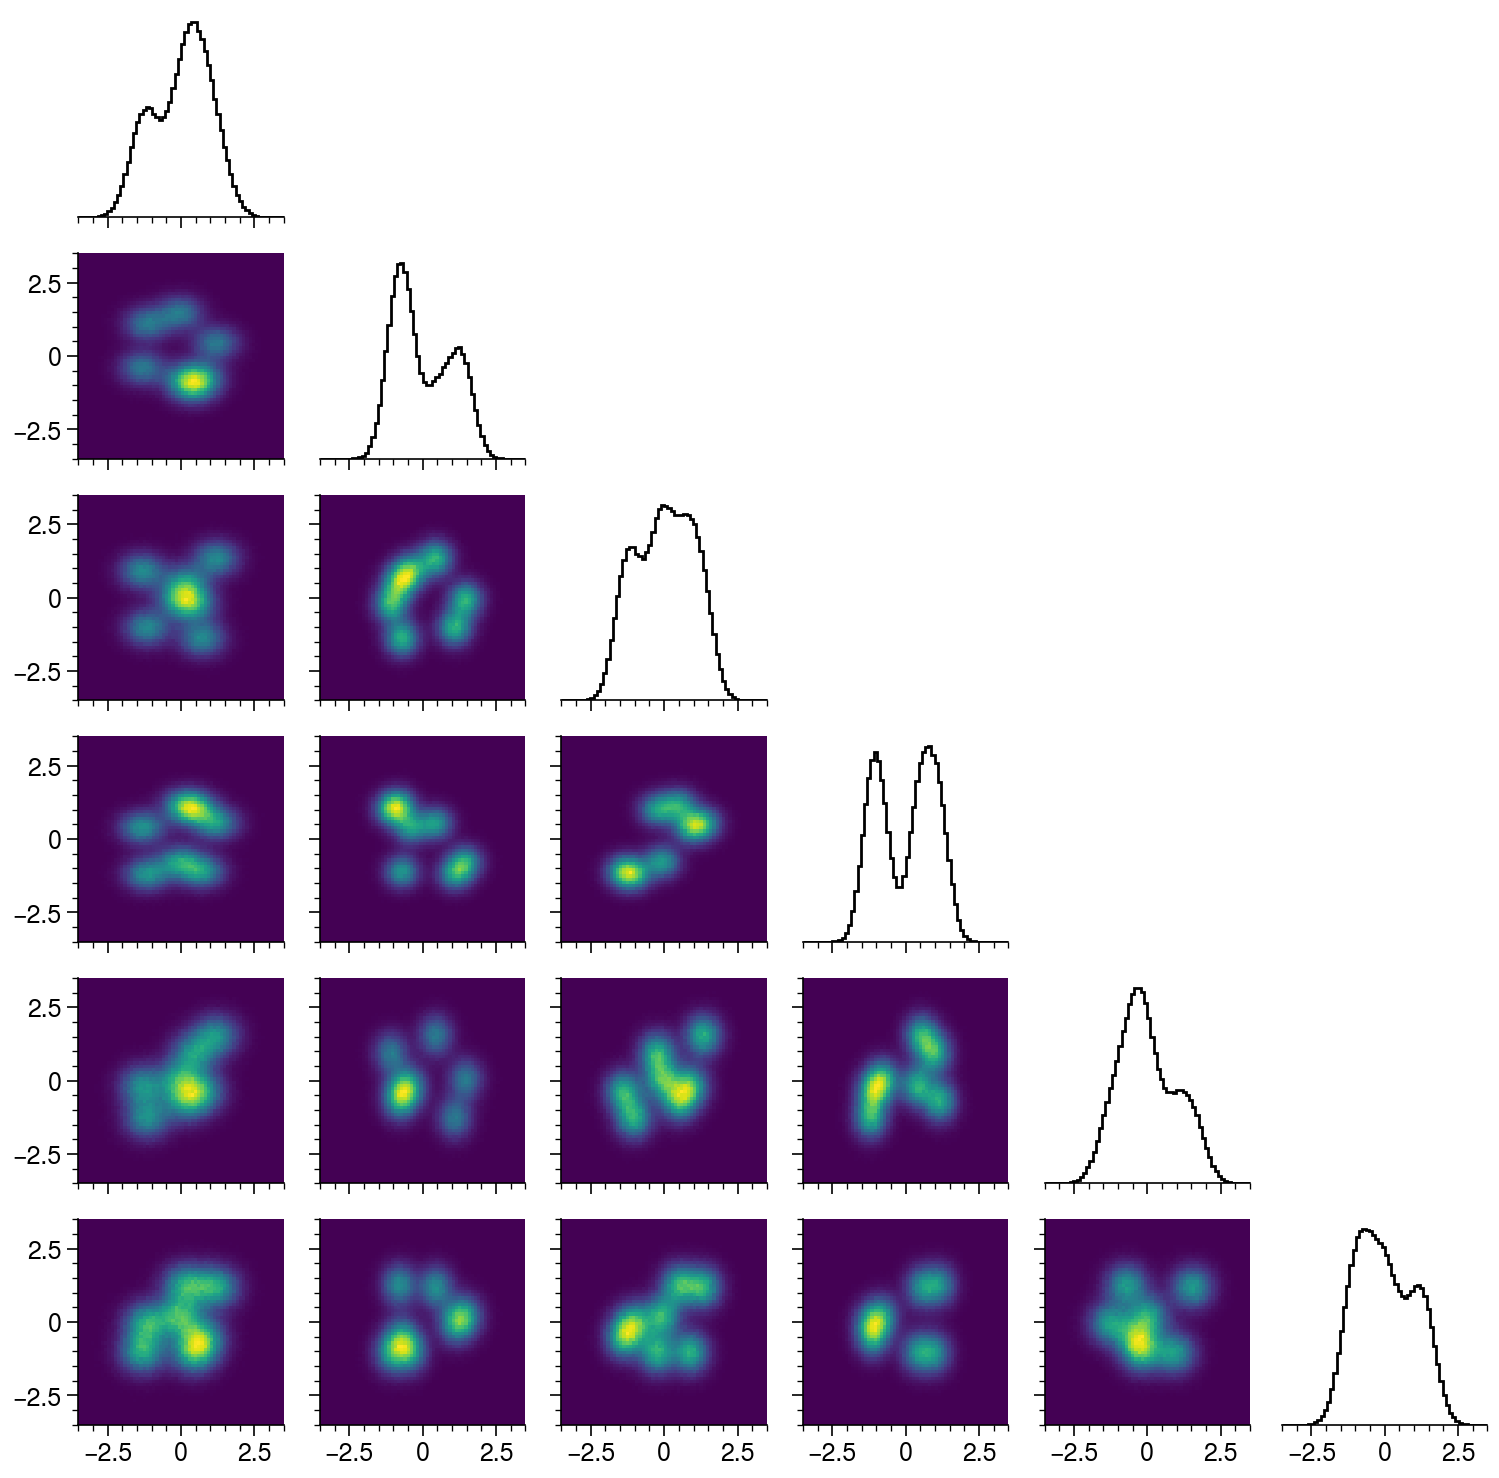

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = ndim * (ndim - 1) // 2
nbins = 64
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

Create phase space transformations (permutation matrices).

In [7]:
transfer_matrices = []
for i in range(ndim):
    for j in range(i):
        matrices = []
        for k, l in zip(axis_meas, (j, i)):
            matrix = np.identity(ndim)
            matrix[k, k] = matrix[l, l] = 0.0
            matrix[k, l] = matrix[l, k] = 1.0
            matrices.append(matrix)
        transfer_matrices.append(
            np.linalg.multi_dot(matrices[::-1])
        )

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

Create histogram diagnostics.

In [8]:
axis_proj = axis_meas
bin_edges = 2 * [np.linspace(-xmax, xmax, nbins + 1)]

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.HistogramND(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
        blur=blur,
        thresh=0.0,
        thresh_type="abs",
    )
    diagnostics.append([diagnostic])

Generate data from the source distribution.

In [9]:
projections = ment.simulate_with_diag_update(
    x_true,
    transforms,
    diagnostics,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

In [10]:
# @interact(index=(0, nmeas - 1))
# def update(index: int):
#     coords = unravel(projections)[index].coords
#     values = unravel(projections)[index].values

#     fig, ax = plt.subplots()
#     ax.pcolormesh(coords[0], coords[1], values.T, colorbar=True,)

## Model

In [11]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

In [12]:
samp_method = "mcmc"

if samp_method == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif samp_method == "mcmc":
    samp_burnin = 500
    samp_chains = 1000
    samp_prop_cov = np.eye(ndim) * (0.5 ** 2)
    samp_start = np.random.normal(size=(samp_chains, ndim)) * 0.50
    
    sampler = ment.MetropolisHastingsSampler(
        ndim=ndim,
        chains=samp_chains,
        start=samp_start,
        proposal_cov=samp_prop_cov,
        burnin=samp_burnin,
        shuffle=True,
        verbose=False,
        debug=False,
        noise_scale=0.10,  # slight smoothing
        noise_type="gaussian",
    )

else:
    raise ValueError

In [13]:
model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=500_000,
    mode="sample",
    verbose=True,
)

In [14]:
sampler.debug = True
model.sample(1000)
sampler.debug = False

debug acceptance rate = None
debug axis=0 between-chain avg(x_chain_std) = 0.8188433237595691
debug axis=0 between-chain std(x_chain_std) = 0.0
debug axis=0 between-chain avg(x_chain_avg) = 0.0426999667622823
debug axis=0 between-chain std(x_chain_avg) = 0.0
debug axis=0 x_std = 0.8188433237595691
debug axis=0 x_avg = 0.0426999667622823
debug axis=1 between-chain avg(x_chain_std) = 0.7660660350745313
debug axis=1 between-chain std(x_chain_std) = 0.0
debug axis=1 between-chain avg(x_chain_avg) = -0.06078938495131793
debug axis=1 between-chain std(x_chain_avg) = 0.0
debug axis=1 x_std = 0.7660660350745313
debug axis=1 x_avg = -0.06078938495131793
debug axis=2 between-chain avg(x_chain_std) = 0.7657449467232235
debug axis=2 between-chain std(x_chain_std) = 0.0
debug axis=2 between-chain avg(x_chain_avg) = 0.030324317765943125
debug axis=2 between-chain std(x_chain_avg) = 0.0
debug axis=2 x_std = 0.7657449467232235
debug axis=2 x_avg = 0.030324317765943125
debug axis=3 between-chain avg(x_

## Training

In [15]:
plot_nsamp = x_true.shape[0]

In [16]:
def plot_model(model):
    figs = []

    # Sample particles
    x_pred = model.sample(plot_nsamp)

    # Plot reconstructed vs. true distribution
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        process_kws=dict(blur=0.0),
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Simulate measurements
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate_with_diag_update(
        x_pred, transforms, projections_pred, kde=False, blur=False
    )

    projections_true = unravel(projections_true)
    projections_pred = unravel(projections_pred)

    # Plot simulated vs. measured projections.
    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, scale="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.9,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for proj_true, proj_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_hist(proj_true, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_hist(proj_pred, ax=ax, colors=contour_colors[1], **plot_kws)
    figs.append(fig)

    return figs

epoch = 0


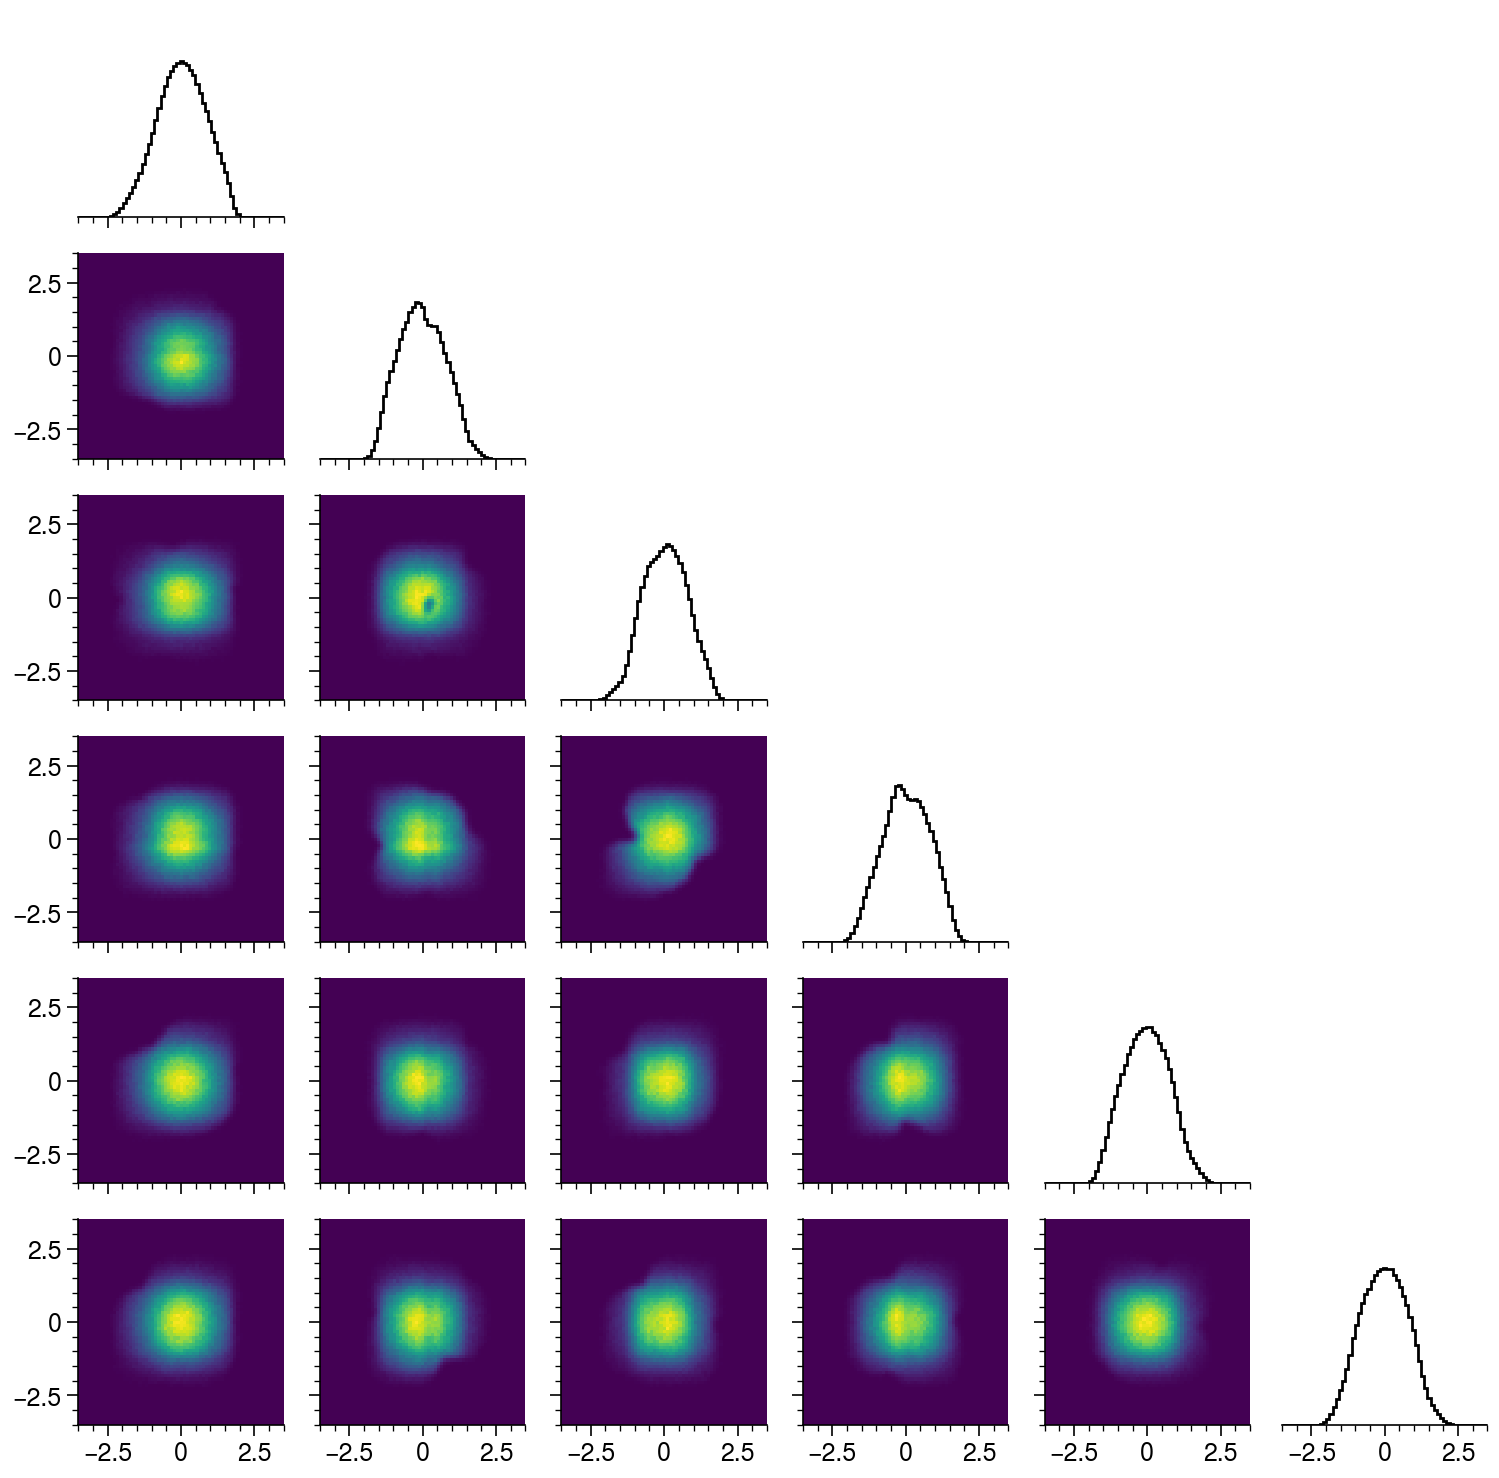

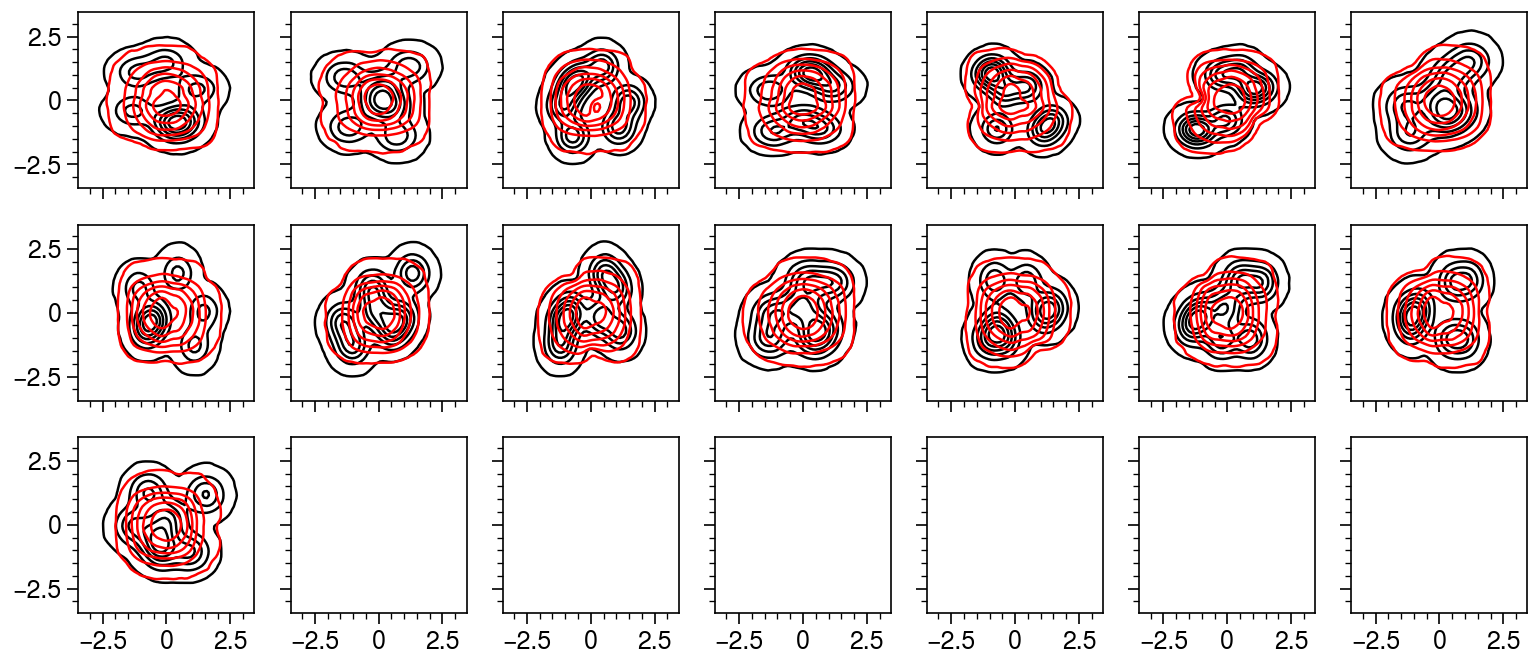

epoch = 1
Finding starting point for MCMC chains
Updating Lagrange multiplier functions
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


transform=9
diagnostic=0


transform=10
diagnostic=0


transform=11
diagnostic=0


transform=12
diagnostic=0


transform=13
diagnostic=0


transform=14
diagnostic=0


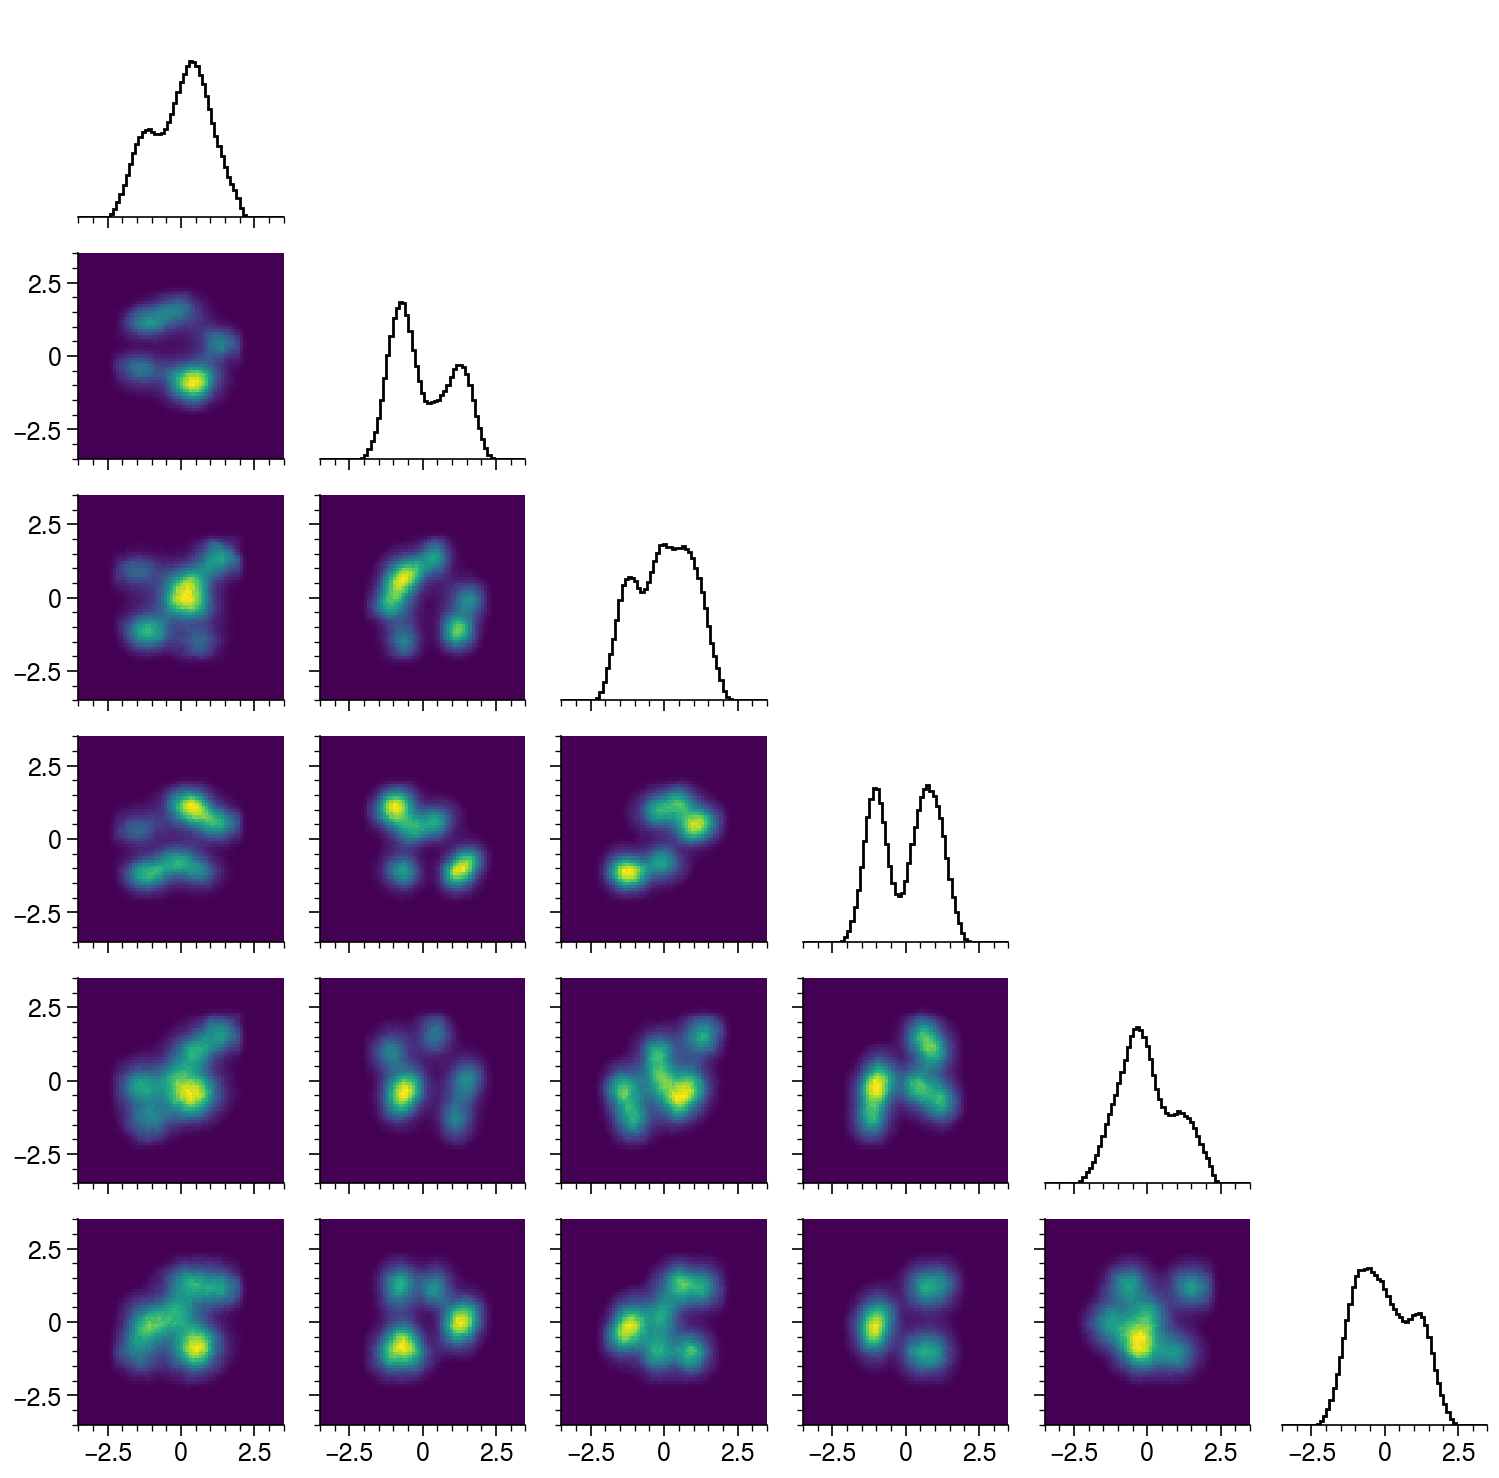

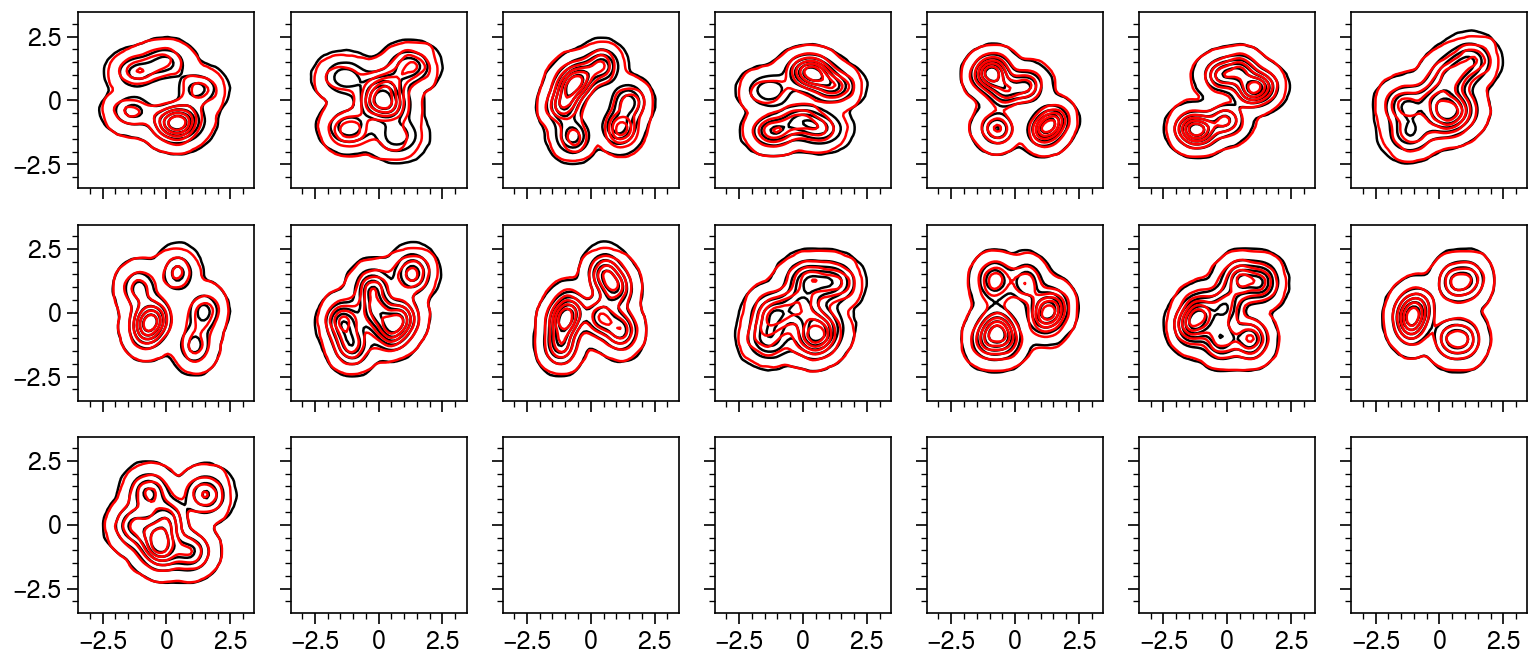

epoch = 2
Finding starting point for MCMC chains
Updating Lagrange multiplier functions
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


transform=9
diagnostic=0


transform=10
diagnostic=0


transform=11
diagnostic=0


transform=12
diagnostic=0


transform=13
diagnostic=0


transform=14
diagnostic=0


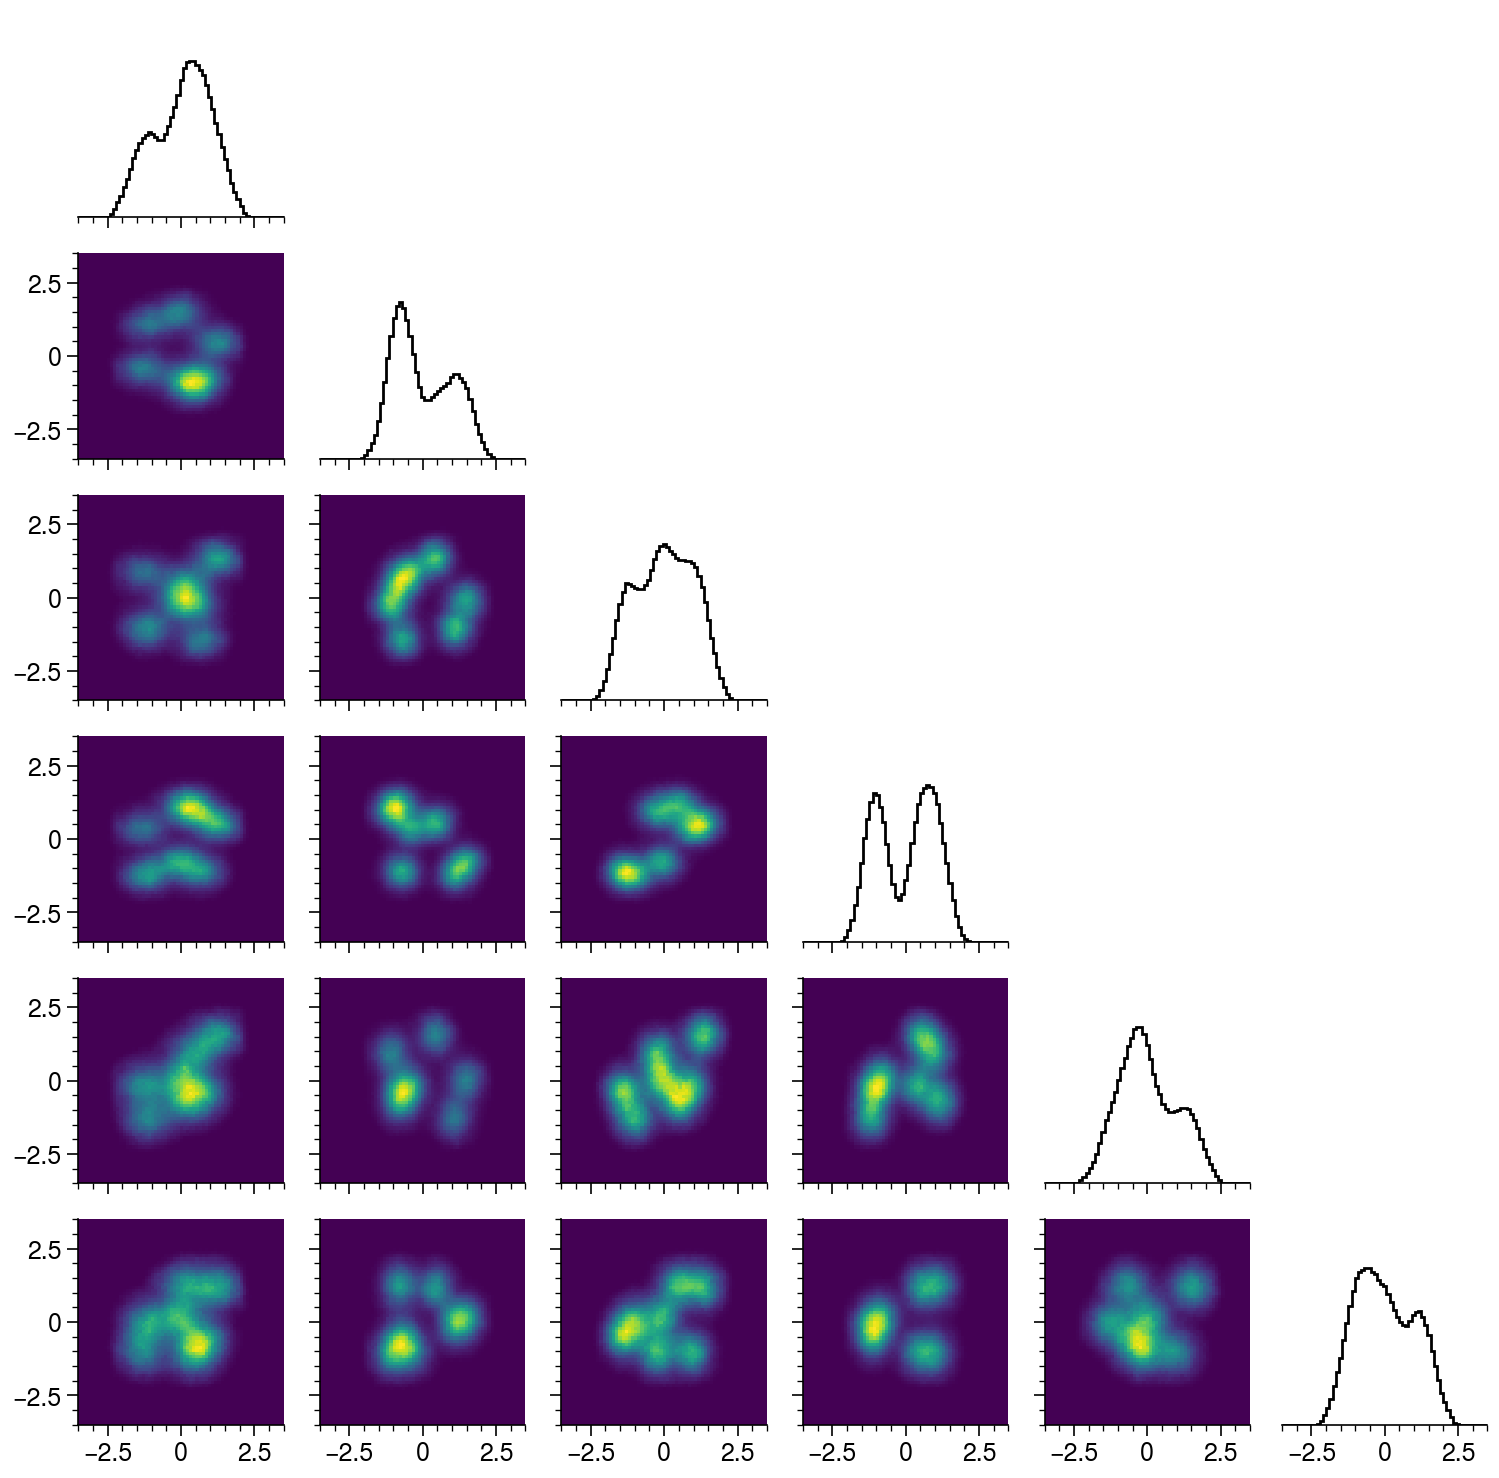

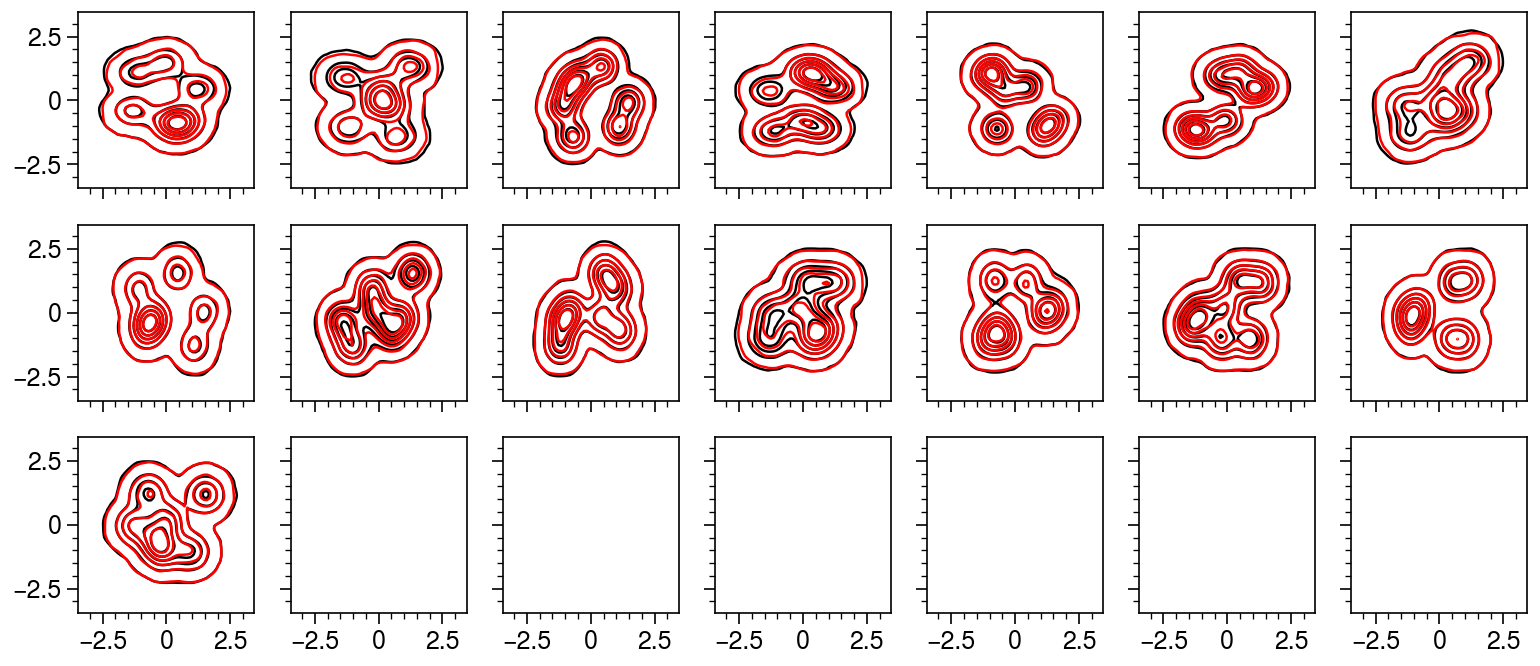

epoch = 3
Finding starting point for MCMC chains
Updating Lagrange multiplier functions
transform=0
diagnostic=0


transform=1
diagnostic=0


transform=2
diagnostic=0


transform=3
diagnostic=0


transform=4
diagnostic=0


transform=5
diagnostic=0


transform=6
diagnostic=0


transform=7
diagnostic=0


transform=8
diagnostic=0


transform=9
diagnostic=0


transform=10
diagnostic=0


transform=11
diagnostic=0


transform=12
diagnostic=0


transform=13
diagnostic=0


transform=14
diagnostic=0


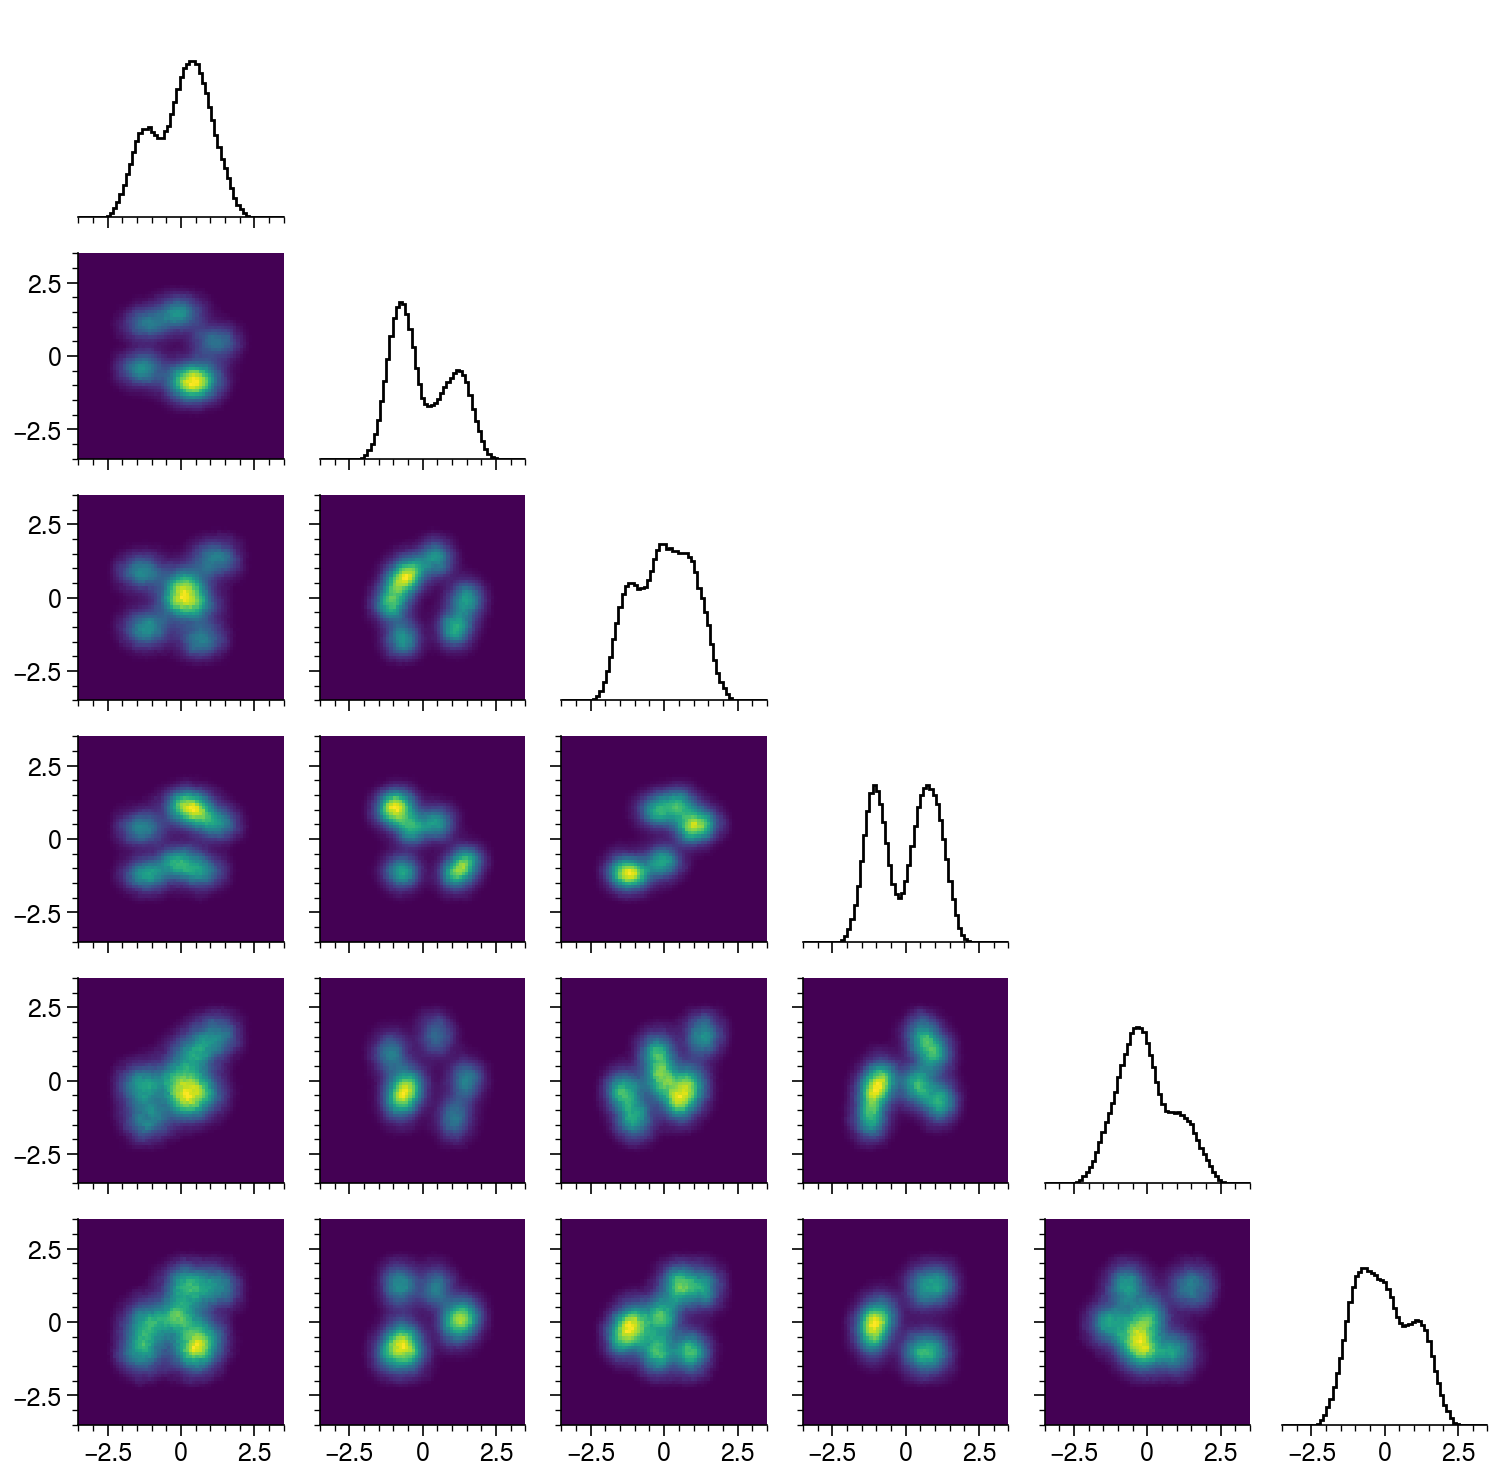

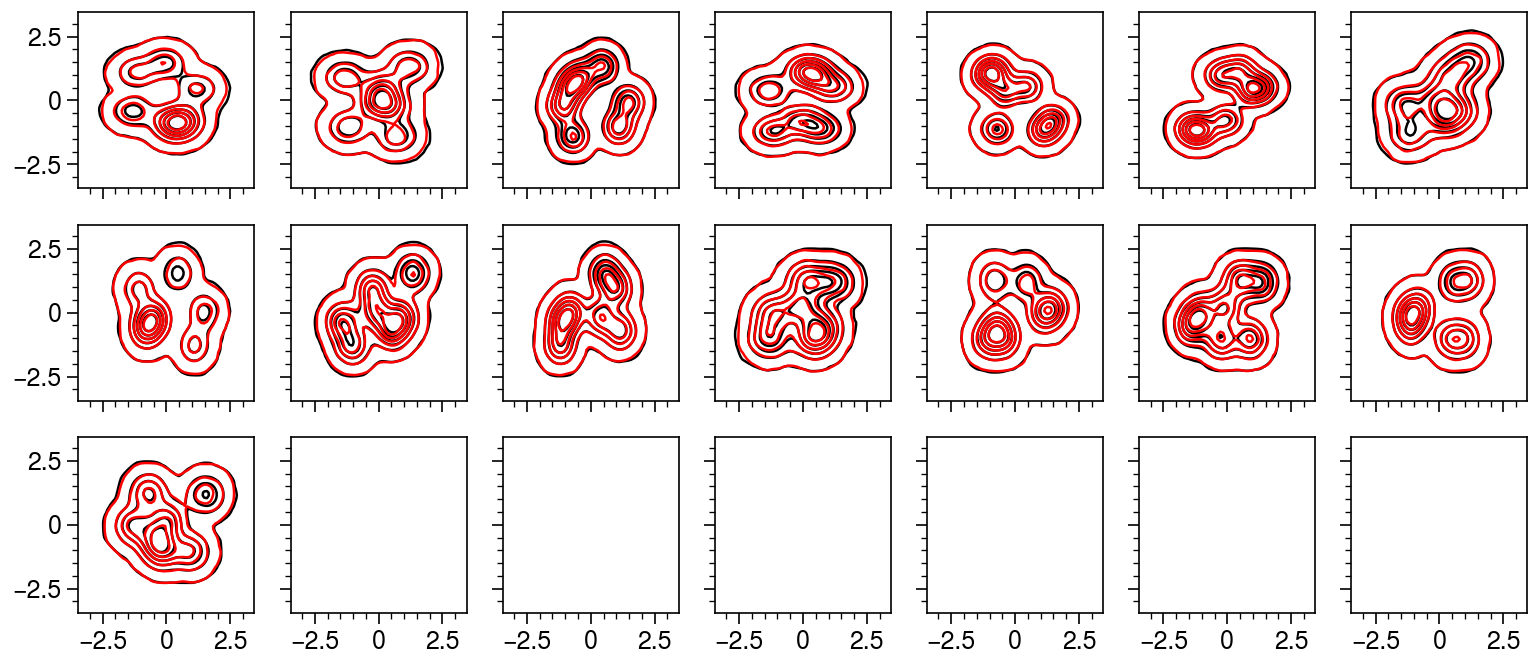

In [17]:
for epoch in range(4):
    print(f"epoch = {epoch}")

    if epoch > 0:
        print("Finding starting point for MCMC chains")
        # model.sampler.start = model.sample(model.sampler.chains)

        print("Updating Lagrange multiplier functions")
        model.gauss_seidel_step(learning_rate=0.80)

    for fig in plot_model(model):
        plt.show()

## Evaluate

In [18]:
x_pred = model.unnormalize(model.sample(1_000_000))

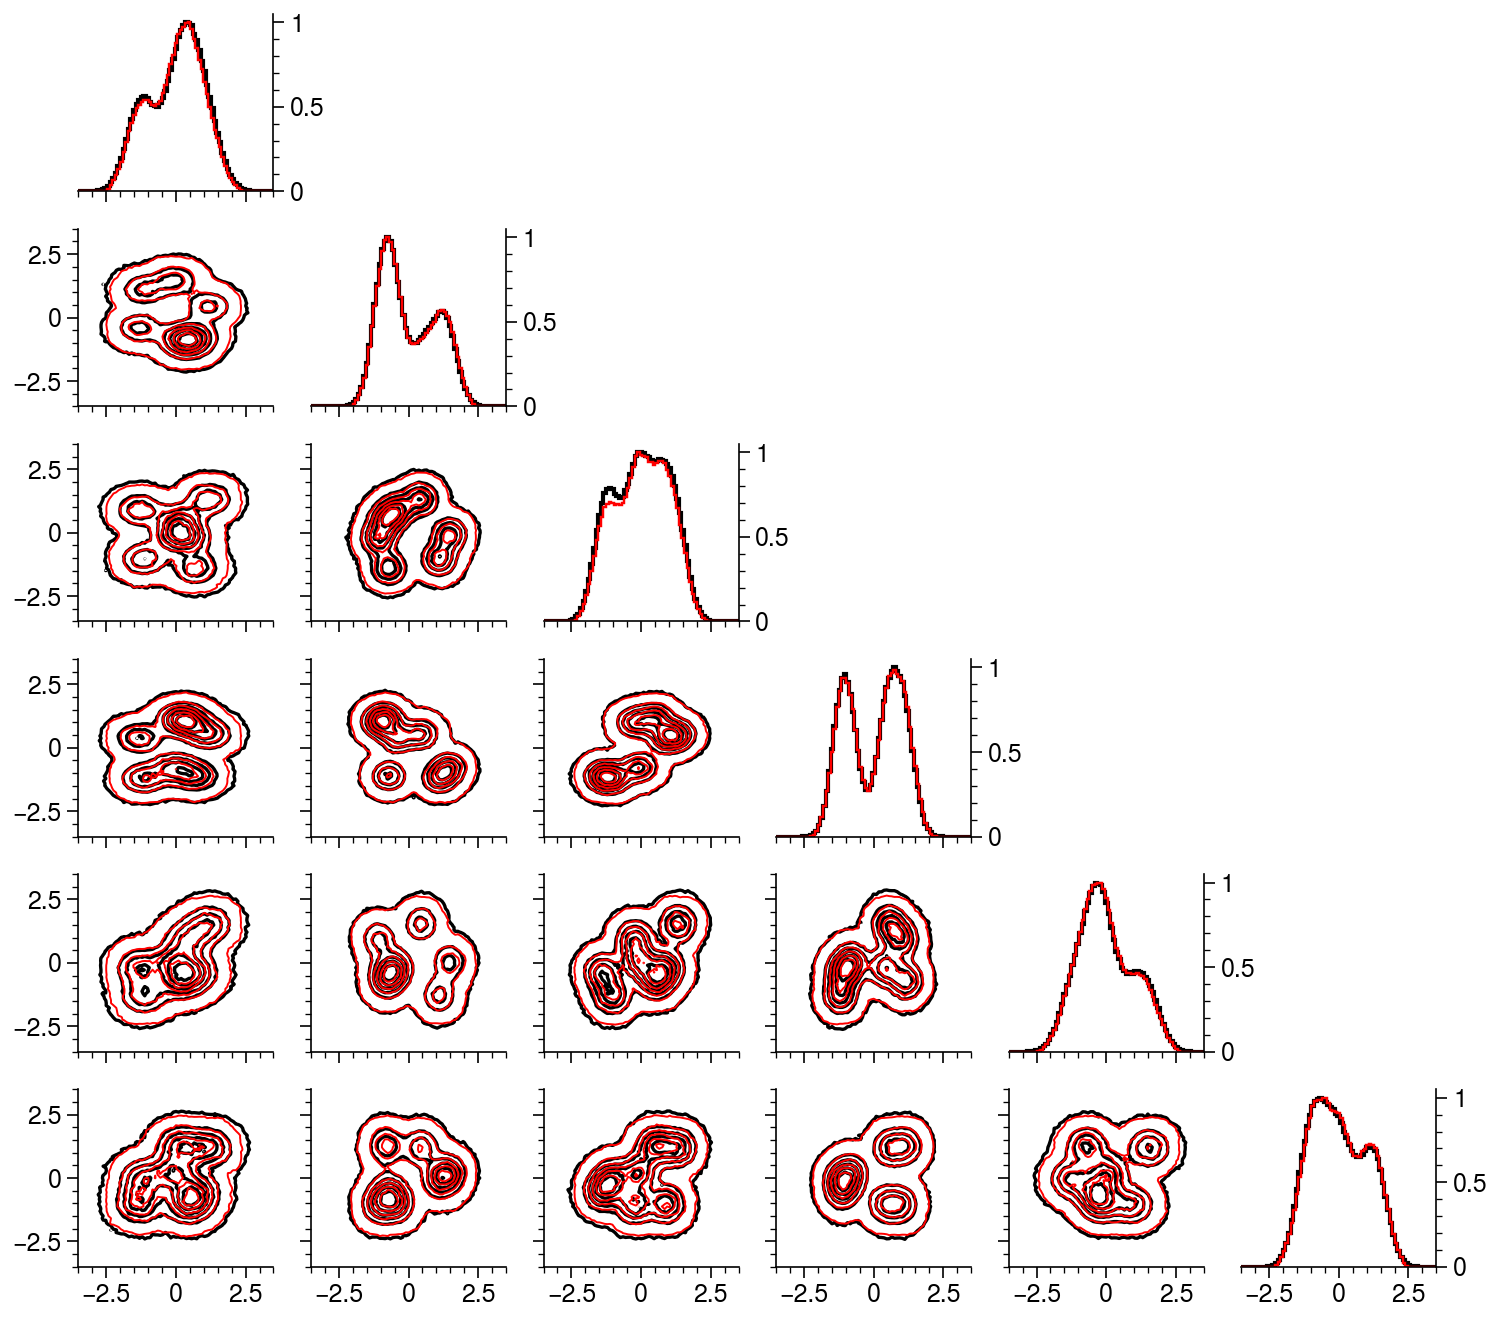

In [19]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=0.0, scale="max"),
        mask=False,
        levels=np.linspace(0.01, 1.0, 7),
        color=color,
        lw=lw,
    )
plt.show()

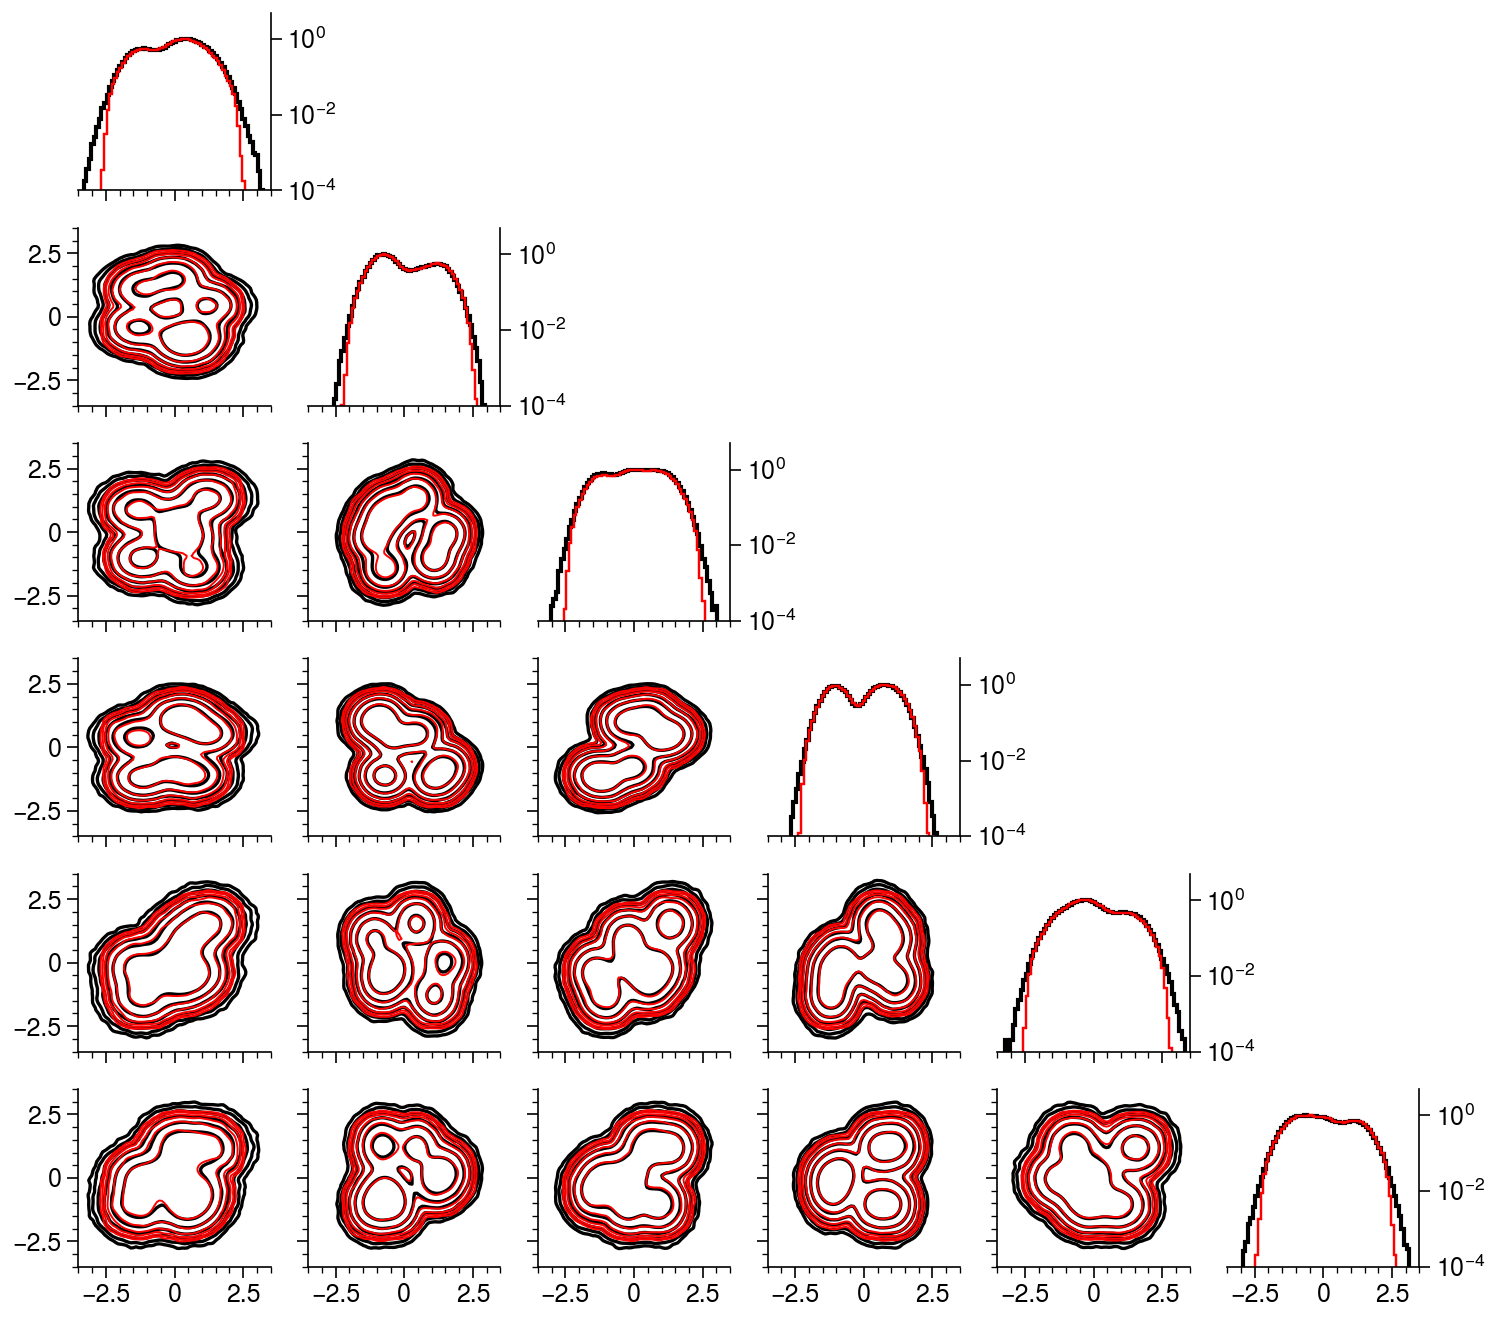

In [20]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=1.0, scale="max"),
        mask=False,
        levels=(10.0 ** np.linspace(-3.0, 0.0, 7)),
        color=color,
        lw=lw,
    )
    grid.format_diag(yscale="log", yformatter="log", ymax=5.0, ymin=0.0001)
plt.show()